In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# Part 1 - Exploratory data analysis


To begin, I import the json data and take a look a the dataset. 

In [ ]:
logins = pd.read_json('logins.json', typ='frame')
logins.head()

In [ ]:
logins.info()

In [ ]:
logins.describe()

Next I resample the dataset and count the number of logins every 15 minutes.

In [5]:
logins_agg_df = logins.resample(rule='15min', on='login_time').count()

In [6]:
logins_agg_df.head()

,login_time
login_time,
1970-01-01 20:00:00,2
1970-01-01 20:15:00,6
1970-01-01 20:30:00,9
1970-01-01 20:45:00,7
1970-01-01 21:00:00,1


I make a new column `time` that holds the login time information without the date. This allows me to look at trends over the course of a single day.

In [7]:
logins_agg_df['time'] = logins_agg_df.index.time

In [8]:
daily_sums = logins_agg_df.groupby(by='time').sum()

Next I use a graph of the rolling average totals

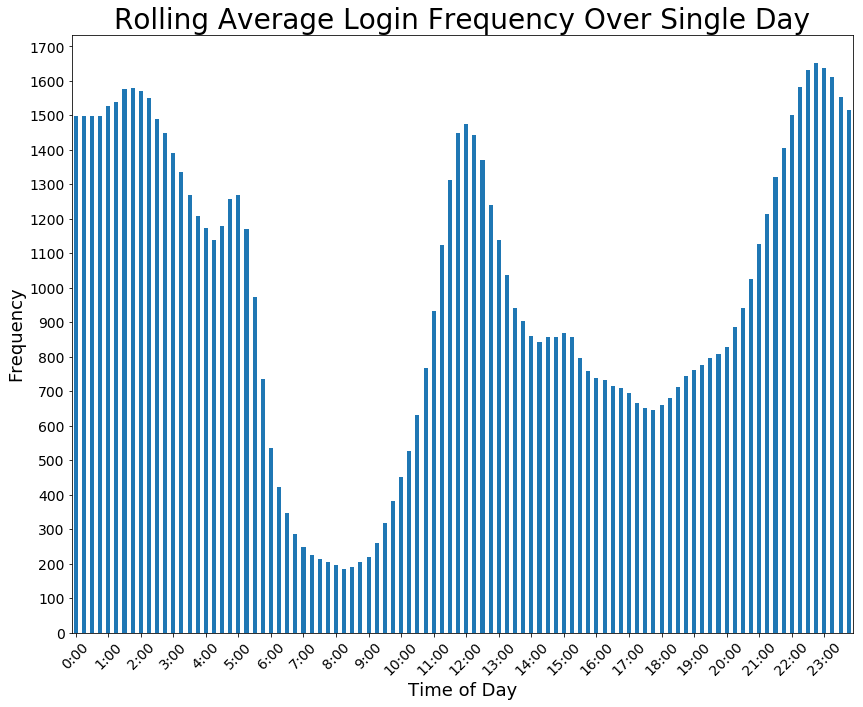

In [9]:
times = [str(i) + ':00' for i in range(0,24)]
rolling = daily_sums.rolling(4).mean().bfill()
ax = rolling.plot(kind='bar', figsize=(14, 11),
                    legend=False)
_ = plt.locator_params(nbins=24)
_ = ax.set_xticklabels(times, fontsize=14, rotation=45)
_ = plt.yticks(fontsize=14)
_ = plt.title('Rolling Average Login Frequency Over Single Day',
              fontsize=28)
_ = plt.xlabel('Time of Day', fontsize=18)
_ = plt.ylabel('Frequency', fontsize=18)

Based on the graph above, there are three major peaks of activity. The most logins occur around 22:00 followed by 01:00 and then around noon.

# Part 2 - Experiment and metrics design

1. The key measure of success for this would be the number of drivers who login in both cities in the same day. If there are more reimbursed drivers working both sides of the bridge, the drivers do not view crossing the bridge as a significant deterrent to servicing both locations.
    

2. a. I would break the drivers randomly into 2 equal groups: a control who will not be reimbursed for tolls and a test group who will be. The one's who will be reimbursed will be alerted to this fact. It is important for them to know about the reimbursement so that they no longer feel limited by the tolls. I would also make sure that the test is not performed during an abnormal time period like a holiday where there would be increased traffic, so my results are not skewed by factors unrelated to the reimbursement program.
   
    b. I will run a z-test to determine whether the difference between both test groups is statistically significant.
    
    c. If there is a significant increase in the drivers operating on both side of the toll road, then I would say the reimbursement was a successful incentive for drivers. An important caveat to note would be how these incentives affect profits for the company. If there is an increase in drivers working both sides of the toll, but the profits do not offset costs, then it may not be worthwhile for Ultimate to reimburse drivers.

# Part 3 - Predictive modeling

## 1. Cleaning, EDA, and Visualizations

In [10]:
import json
with open('ultimate_data_challenge.json') as datafile:
    data = json.load(datafile)
retention_df = pd.DataFrame(data)

In [11]:
retention_df.head()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,last_trip_date,phone,signup_date,surge_pct,trips_in_first_30_days,ultimate_black_user,weekday_pct
0,3.67,5.0,4.7,1.10,King's Landing,2014-06-17,iPhone,2014-01-25,15.4,4,True,46.2
1,8.26,5.0,5.0,1.00,Astapor,2014-05-05,Android,2014-01-29,0.0,0,False,50.0
2,0.77,5.0,4.3,1.00,Astapor,2014-01-07,iPhone,2014-01-06,0.0,3,False,100.0
3,2.36,4.9,4.6,1.14,King's Landing,2014-06-29,iPhone,2014-01-10,20.0,9,True,80.0
4,3.13,4.9,4.4,1.19,Winterfell,2014-03-15,Android,2014-01-27,11.8,14,False,82.4


In [12]:
retention_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
avg_dist                  50000 non-null float64
avg_rating_by_driver      49799 non-null float64
avg_rating_of_driver      41878 non-null float64
avg_surge                 50000 non-null float64
city                      50000 non-null object
last_trip_date            50000 non-null object
phone                     49604 non-null object
signup_date               50000 non-null object
surge_pct                 50000 non-null float64
trips_in_first_30_days    50000 non-null int64
ultimate_black_user       50000 non-null bool
weekday_pct               50000 non-null float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.2+ MB


The date columns need to be converted to datetime objects to make analysis easier. I am also going to create dummy variable columns for the 3 cities and 2 phone types.

In [13]:
retention_df['signup_date'] = pd.to_datetime(retention_df['signup_date'])
retention_df['last_trip_date'] = pd.to_datetime(retention_df['last_trip_date'])
retention_df = pd.get_dummies(retention_df, dtype=np.int64)

In [14]:
retention_df.loc[:, ['signup_date', 'last_trip_date']].describe()

,signup_date,last_trip_date
count,50000,50000
unique,31,182
top,2014-01-18 00:00:00,2014-06-29 00:00:00
freq,2948,2036
first,2014-01-01 00:00:00,2014-01-01 00:00:00
last,2014-01-31 00:00:00,2014-07-01 00:00:00


Based off of this information, this data was taken from July 1, 2014. Since a retained rider is said to have taken a ride in the last 30 days, I need to note all the riders that have a `last_trip_date` after June 1, 2014.

In [15]:
retention_df['active'] = retention_df['last_trip_date'] > '2014-06-01'
retention_df['active'] = retention_df['active'].apply(np.int64)
retention_df.head()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,last_trip_date,signup_date,surge_pct,trips_in_first_30_days,ultimate_black_user,weekday_pct,city_Astapor,city_King's Landing,city_Winterfell,phone_Android,phone_iPhone,active
0,3.67,5.0,4.7,1.10,2014-06-17,2014-01-25,15.4,4,True,46.2,0,1,0,0,1,1
1,8.26,5.0,5.0,1.00,2014-05-05,2014-01-29,0.0,0,False,50.0,1,0,0,1,0,0
2,0.77,5.0,4.3,1.00,2014-01-07,2014-01-06,0.0,3,False,100.0,1,0,0,0,1,0
3,2.36,4.9,4.6,1.14,2014-06-29,2014-01-10,20.0,9,True,80.0,0,1,0,0,1,1
4,3.13,4.9,4.4,1.19,2014-03-15,2014-01-27,11.8,14,False,82.4,0,0,1,1,0,0


In [16]:
retention_df['active'].sum() / len(retention_df['active'])

0.3662

The retention rate for the dataset was 36.6%.

In [17]:
# Convert ultimate_black_user to int
retention_df['ultimate_black_user'] = retention_df['ultimate_black_user'].apply(np.int8)

In [18]:
retention_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 16 columns):
avg_dist                  50000 non-null float64
avg_rating_by_driver      49799 non-null float64
avg_rating_of_driver      41878 non-null float64
avg_surge                 50000 non-null float64
last_trip_date            50000 non-null datetime64[ns]
signup_date               50000 non-null datetime64[ns]
surge_pct                 50000 non-null float64
trips_in_first_30_days    50000 non-null int64
ultimate_black_user       50000 non-null int64
weekday_pct               50000 non-null float64
city_Astapor              50000 non-null int64
city_King's Landing       50000 non-null int64
city_Winterfell           50000 non-null int64
phone_Android             50000 non-null int64
phone_iPhone              50000 non-null int64
active                    50000 non-null int64
dtypes: datetime64[ns](2), float64(6), int64(8)
memory usage: 6.1 MB


In [19]:
# Investigate correlations between features and target variable
retention_df.corr()['active']

avg_dist                 -0.090279
avg_rating_by_driver     -0.025635
avg_rating_of_driver     -0.010834
avg_surge                -0.003567
surge_pct                 0.010612
trips_in_first_30_days    0.214728
ultimate_black_user       0.210259
weekday_pct               0.026413
city_Astapor             -0.179373
city_King's Landing       0.268272
city_Winterfell          -0.046985
phone_Android            -0.231731
phone_iPhone              0.231391
active                    1.000000
Name: active, dtype: float64

After performing quick correlation test on the dataset, `trips_in_first_30_days`, `ultimate_black_user`, `city_King's Landing`, and `phone_iPhone` are most positively correlated with customer retention, and `city_Astapor` and `phone_Android` are the most negatively correlated.


I then created histograms of each feature to understand their distributions. I have only included a representative group below.

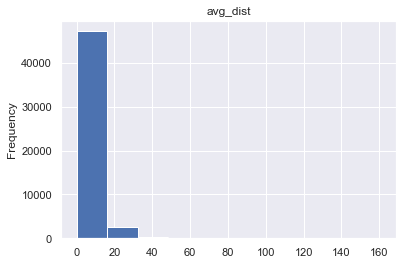

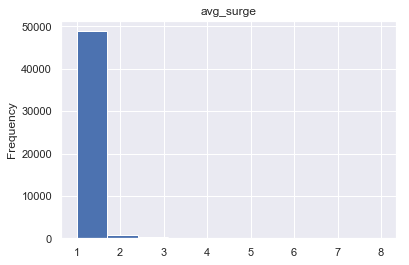

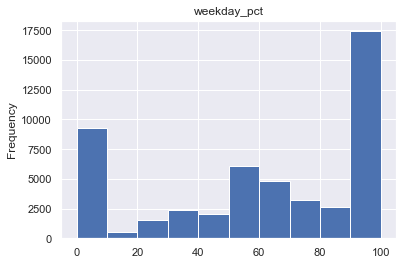

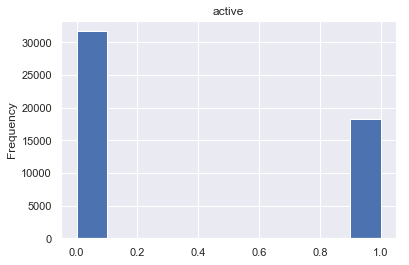

In [20]:
sns.set()
for col in ['avg_dist', 'avg_surge', 
            'weekday_pct', 'active']:
    _ = plt.hist(retention_df[col])
    _ = plt.ylabel('Frequency')
    _ = plt.title(col)
    _ = plt.show()

Many of the columns had a distribution with many observations around a single value with a few outliers such as `avg_dist` and `avg_surge`. `weekday_pct` had an interesting distribution with 2 distinct peaks on both ends and a small one in the middle signifying that many riders will use Ultimate nearly exclusively on the weekends or exclusively on the weekends. Many of the columns are binary data such as `active`

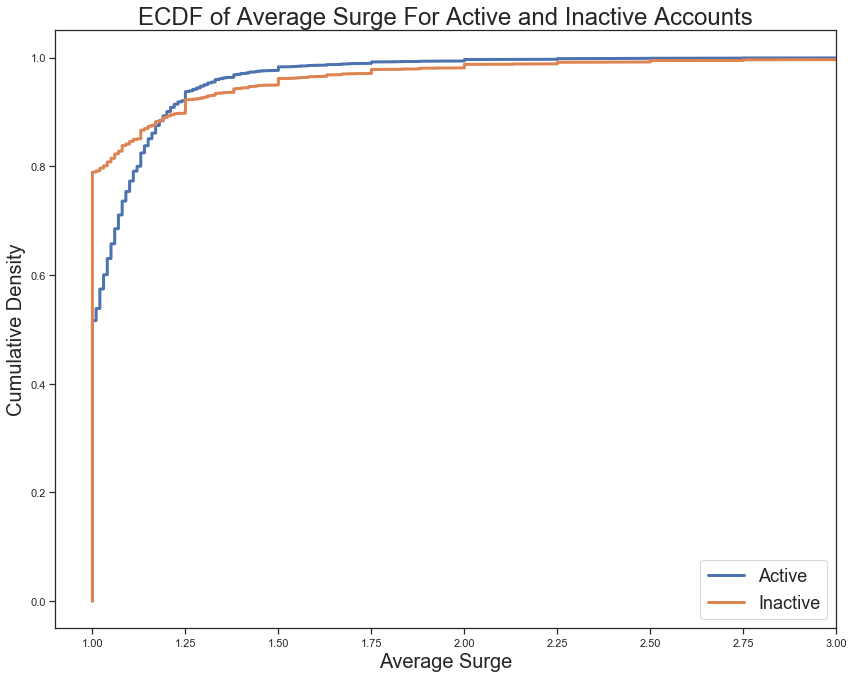

In [21]:
# Make ECDF of avg_surge of those who are active and those that are not
sns.set(style='ticks')
x1 = np.sort(retention_df[retention_df['active'] == 1]['avg_surge'])
n1 = x1.size
y1 = np.arange(0, n1) / n1
x2 = np.sort(retention_df[retention_df['active'] == 0]['avg_surge'])
n2 = x2.size
y2 = np.arange(0, n2) / n2

_ = plt.figure(figsize=(14, 11))
_ = plt.plot(x1,y1, label='Active', linewidth=3)
_ = plt.plot(x2,y2, label='Inactive', linewidth=3)
_ = plt.xlabel('Average Surge', fontsize=20)
_ = plt.ylabel('Cumulative Density', fontsize=20)
_ = plt.xlim(.9, 3)
_ = plt.legend(loc='lower right', fontsize=18)
_ = plt.title('ECDF of Average Surge For Active and Inactive Accounts',
             fontsize=24)
_ = plt.show()

## Takeaways:
- 36.6% of drivers are active after 6 months
- Data is balanced so no subsampling will be required.
- It appears that driver location can impact retention and so can the type of phone the person uses.
- From the ECDF, the Inactive driver's line takes longer to reach 100% which means that a greater percentage of them are experiencing very higher surge prices. Perhaps people who encounter high surges will have lower likelihood of retention.

## 2. Predictive Model

Before I begin my predictive modelling, there are some null values in the ratings of both drivers and riders. I am going to drop these since there is a sample of 41,878 without the incomplete rows.

In [22]:
retention_df = retention_df.dropna()

The question is a classification problem. I want to predict whether a person will be active after 6 months. 

Classification algorithms:
- Logistic Regression
- Random Forest Classifier
- K-Nearest Neighbor Classification
- Naive Bayes
- Support Vector Machine Classifier

In [23]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC

int_df = retention_df.select_dtypes(exclude=['datetime64'])
features = int_df.loc[:, int_df.columns != 'active']
target = int_df.loc[:, 'active']

X_train, X_test, y_train, y_test = train_test_split(features, target,
                                                   test_size=0.3)
scaler = StandardScaler()

# Create list of classifiers
classifiers = dict()

rfc = RandomForestClassifier(n_estimators=100)
classifiers['Random Forest'] = rfc

lr = LogisticRegression(solver='lbfgs')
classifiers['Logistic Regression'] = lr

nb = GaussianNB()
classifiers['Naive Bayes'] = nb

knc = KNeighborsClassifier()
classifiers['K-Neighbors'] = knc

svc = LinearSVC()
classifiers['SVC'] = svc



In [24]:
for name, clf in classifiers.items():
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    print("Accuracy of %s is %s" % (name, acc))
    cm = confusion_matrix(y_test, y_pred)
    print("Confusion Matrix of %s is %s" % (name, cm))
    cr = classification_report(y_test, y_pred)
    print("Classification Report of %s is %s \n" % (name, cr))

Accuracy of Random Forest is 0.7583839029064197
Confusion Matrix of Random Forest is [[6055 1468]
 [1558 3443]]
Classification Report of Random Forest is               precision    recall  f1-score   support

           0       0.80      0.80      0.80      7523
           1       0.70      0.69      0.69      5001

    accuracy                           0.76     12524
   macro avg       0.75      0.75      0.75     12524
weighted avg       0.76      0.76      0.76     12524
 



C:\Users\Drew\AppData\Roaming\Python\Python36\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


Accuracy of Logistic Regression is 0.7148674544873842
Confusion Matrix of Logistic Regression is [[6234 1289]
 [2282 2719]]
Classification Report of Logistic Regression is               precision    recall  f1-score   support

           0       0.73      0.83      0.78      7523
           1       0.68      0.54      0.60      5001

    accuracy                           0.71     12524
   macro avg       0.71      0.69      0.69     12524
weighted avg       0.71      0.71      0.71     12524
 

Accuracy of Naive Bayes is 0.6987384222293197
Confusion Matrix of Naive Bayes is [[5030 2493]
 [1280 3721]]
Classification Report of Naive Bayes is               precision    recall  f1-score   support

           0       0.80      0.67      0.73      7523
           1       0.60      0.74      0.66      5001

    accuracy                           0.70     12524
   macro avg       0.70      0.71      0.70     12524
weighted avg       0.72      0.70      0.70     12524
 

Accuracy of K-Neighbor

C:\Users\Drew\AppData\Roaming\Python\Python36\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
